# Income Analysis  

## Import & Clean Data

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
import os
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
import mne
from mne.stats import bonferroni_correction, fdr_correction

In [2]:
income = pd.read_csv("income_data.csv", sep=r'\s*,\s*', engine='python')
income.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
#clean the variable name 
income['marital_status'] = income['marital-status']
income['education_num'] = income['education-num']
income['capital_gain'] = income['capital-gain']
income['capital_loss'] = income['capital-loss']
income['hours_per_week'] = income['hours-per-week']
income['native_country'] = income['native-country']
unclean_names = ['marital-status', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
income = income.drop(unclean_names, 1)

In [4]:
#merging levels of education
income['education']=np.where(income['education'] =='11th', 'Not-HS-Grad', income['education'])
income['education']=np.where(income['education'] =='9th', 'Not-HS-Grad', income['education'])
income['education']=np.where(income['education'] =='7th-8th', 'Not-HS-Grad', income['education'])
income['education']=np.where(income['education'] =='5th-6th', 'Not-HS-Grad', income['education'])
income['education']=np.where(income['education'] =='10th', 'Not-HS-Grad', income['education'])
income['education']=np.where(income['education'] =='1st-4th', 'Not-HS-Grad', income['education'])
income['education']=np.where(income['education'] =='Preschool', 'Not-HS-Grad', income['education'])
income['education']=np.where(income['education'] =='12th', 'Not-HS-Grad', income['education'])

In [5]:
income_raw = income.copy()

## EDA

### Part 1. Y = whether income > 50k

**1) Occupation**    
    a. Exec-managerial occupation shows more even distribution for people earn over 50k and under 50k.   
    b. people work in the adm-clerical, other-service, sales, craft-repaire field show large disparency of income level.

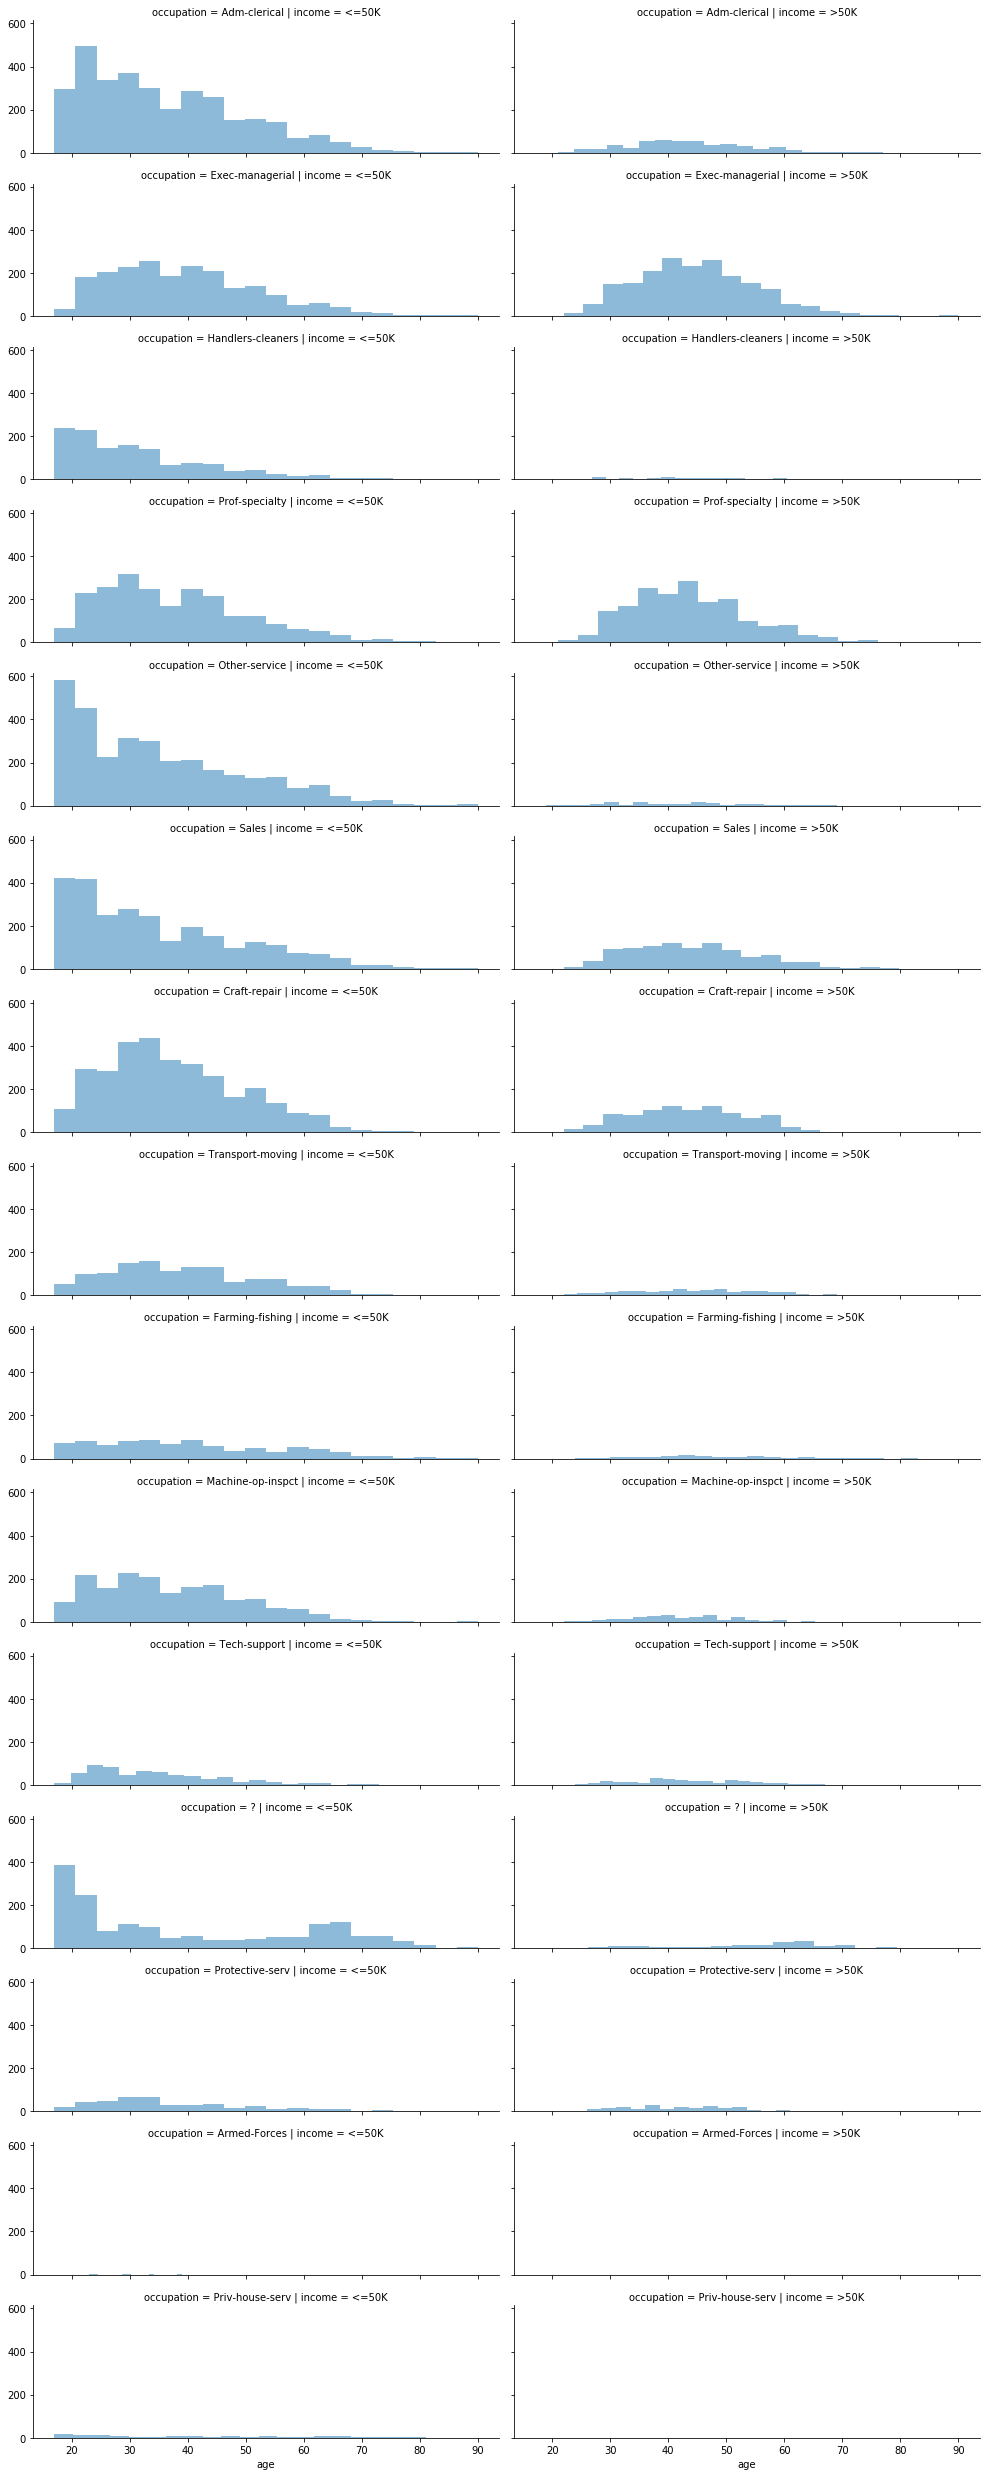

In [6]:
grid = sns.FacetGrid(income, col='income', row='occupation',height=2.3, aspect=3)
grid.map(plt.hist, 'age', alpha=.5, bins=20)
grid.add_legend();

**2) Age**  
Age of people with income over 50k are normally distributed, centered on middle age - 40 to 45 years old.   
Age distribution of people with income less than 50k are right skewed. 


Text(0.5, 0, 'Age')

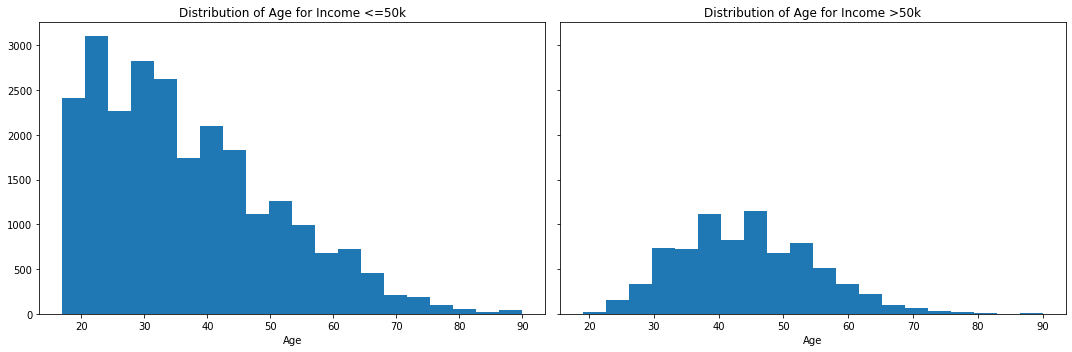

In [7]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize = (15,5))

axs[0].hist(income[income["income"] == "<=50K"]["age"], bins=20)
axs[0].set_title("Distribution of Age for Income <=50k")
axs[0].set_xlabel("Age")
axs[1].hist(income[income["income"] == ">50K"]["age"], bins=20)
axs[1].set_title("Distribution of Age for Income >50k")
axs[1].set_xlabel("Age")

**3) Education Level**

Education level plays an important role in terms of its effect on whether people can earn over 50k. But the effect dramatally decreases when reaching the level of master degree????.

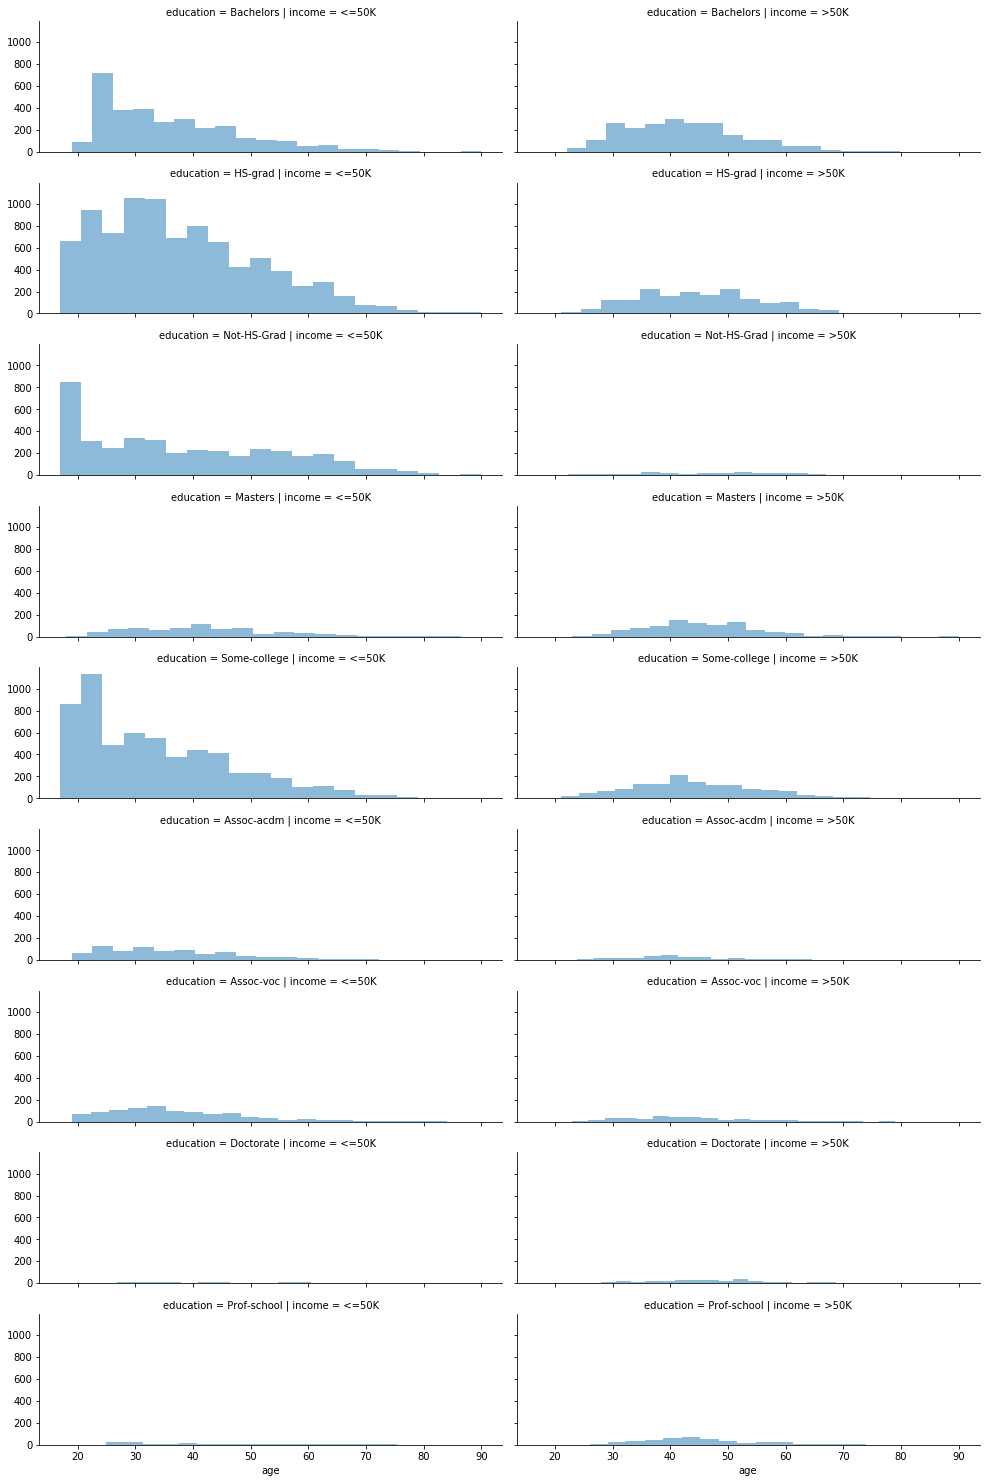

In [8]:
grid = sns.FacetGrid(income, col='income', row='education',height=2.3, aspect=3)
grid.map(plt.hist, 'age', alpha=.5, bins=20)
grid.add_legend();

**4) Working Hours**  
Working overtime -> income >50k

Text(0.5, 0, 'Weekly Working Hours')

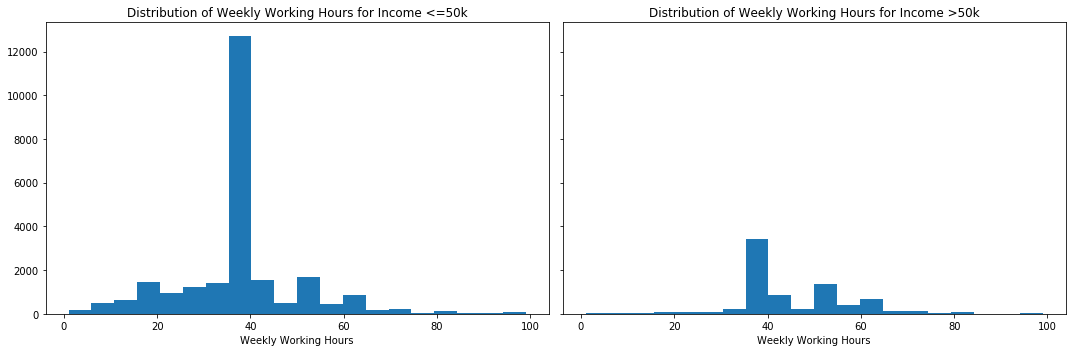

In [9]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize = (15,5))

axs[0].hist(income[income["income"] == "<=50K"]["hours_per_week"], bins=20)
axs[0].set_title("Distribution of Weekly Working Hours for Income <=50k")
axs[0].set_xlabel("Weekly Working Hours")
axs[1].hist(income[income["income"] == ">50K"]["hours_per_week"], bins=20)
axs[1].set_title("Distribution of Weekly Working Hours for Income >50k")
axs[1].set_xlabel("Weekly Working Hours")

### Part 2. Y = Working Hours per Week

1) Workclass

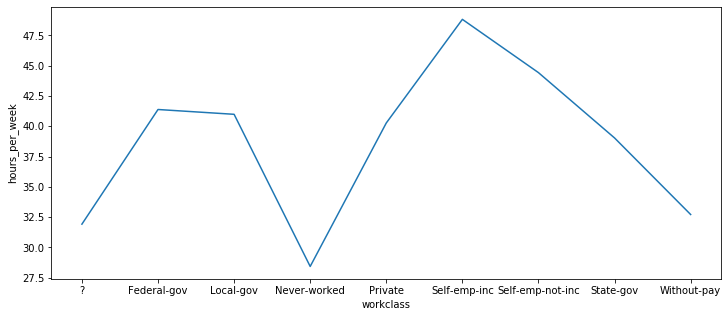

In [10]:
income.groupby('education')['hours_per_week'].agg(Sum='sum', Count='count')
plt.figure(figsize=(12,5))
grp_class=income.groupby('workclass')['hours_per_week'].mean().reset_index()
sp=sns.lineplot(
    x='workclass',
    y='hours_per_week',
    data=grp_class)
sp

2) Education

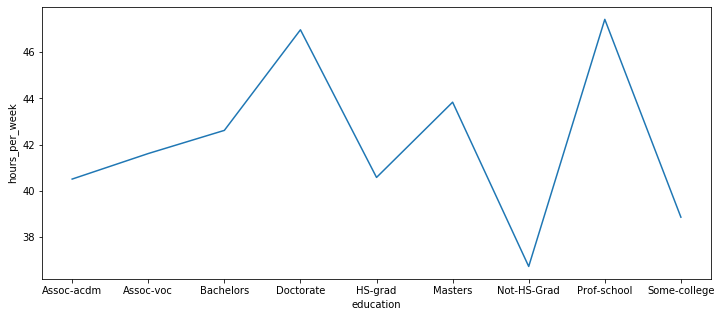

In [11]:
plt.figure(figsize=(12,5))
grp_edu=income.groupby('education')['hours_per_week'].mean().reset_index()
sp1=sns.lineplot(
    x='education',
    y='hours_per_week',
    data=grp_edu)
sp1

## Feature Elimination (Q3)

### Part 1. Elimination by EDA

**1) Investment**  
Compared to those who did not investment at all, people had either 'Capital-gain' or 'Capital-loss' are more likely to earn 50k or more. One possible explanation is that only those people with higher income have the ability and resources to make investment. 


In [12]:
# Tranform Capital Loss & Capital Gain into Logical variable
income['boolean_capital_gain'] = np.where((income["capital_gain"] == 0), "Zero Gain", "Gain")
income['boolean_capital_loss'] = np.where((income["capital_loss"] == 0), "Zero Loss", "Loss")

Text(0, 0.5, '')

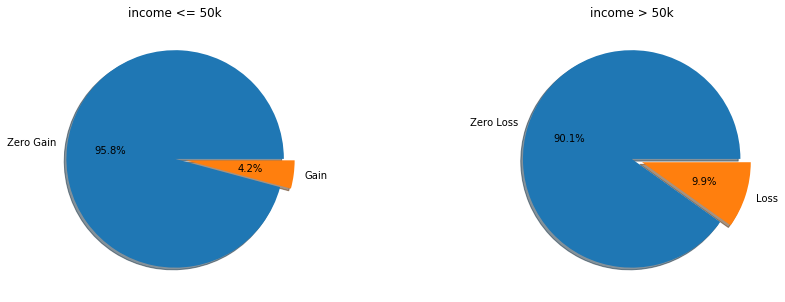

In [13]:
# Capital-Gain vs. High Income
f,ax=plt.subplots(1,2,figsize=(15,5))
income[income["income"] == "<=50K"]["boolean_capital_gain"].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('income <= 50k')
ax[0].set_ylabel('')
income[income["income"] == ">50K"]["boolean_capital_loss"].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[1],shadow=True)
ax[1].set_title('income > 50k')
ax[1].set_ylabel('')

Text(0, 0.5, '')

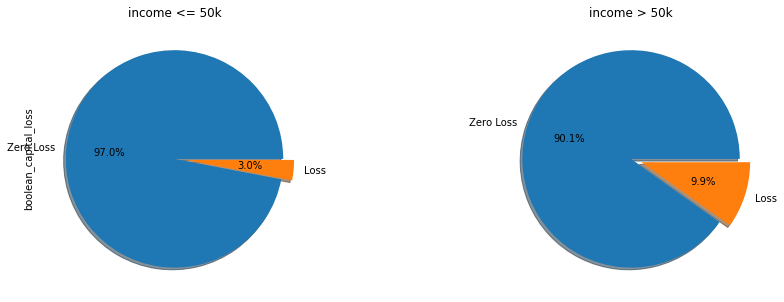

In [14]:
# Capital-Loss vs. High Income
f,ax=plt.subplots(1,2,figsize=(15,5))
income[income["income"] == "<=50K"]["boolean_capital_loss"].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('income <= 50k')
ax[1].set_ylabel('')
income[income["income"] == ">50K"]["boolean_capital_loss"].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[1],shadow=True)
ax[1].set_title('income > 50k')
ax[1].set_ylabel('')

Text(0, 0.5, 'High Salary')

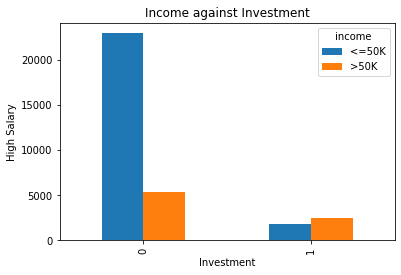

In [15]:
# Combined Capital-Gain & Loss to create new variable 'Invenstment' - whether people invested or not
income['investment'] = np.where(((income["capital_gain"] == 0) & (income["capital_loss"] == 0)), 0, 1)
pd.crosstab(income['investment'],income['income']).plot(kind='bar')
plt.title('Income against Investment')
plt.xlabel('Investment')
plt.ylabel('High Salary')

**2) Choice between Education Level vs Years of Education**  
They two are highly correlated. So we chose enducation level, which has lesser levels. 

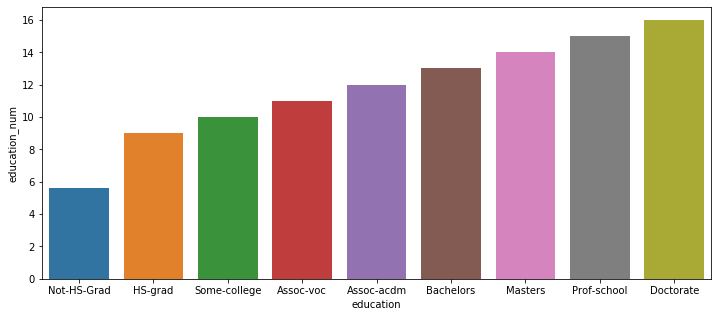

In [16]:
grp_edu=income.groupby('education').mean().reset_index()
# reorder the education level
order_edu = ["Not-HS-Grad", "HS-grad", "Some-college", "Assoc-voc", "Assoc-acdm", "Bachelors", "Masters", "Prof-school", "Doctorate"]

plt.figure(figsize=(12,5))

edu =sns.barplot(
    x='education',
    y='education_num',
    data=grp_edu,
    order = order_edu)
edu

**3) Race**  
Unbalanced Data - drop race


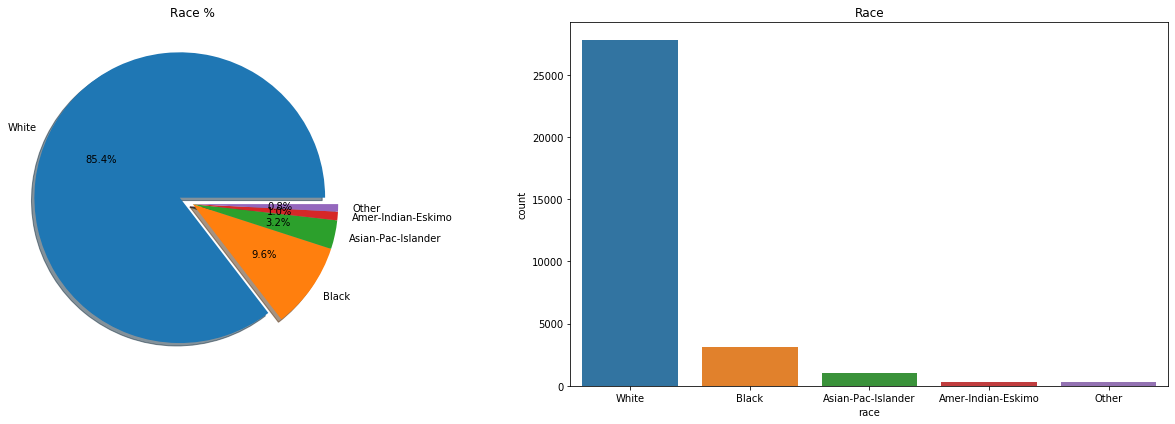

In [17]:
f,ax=plt.subplots(1,2,figsize=(18,6), tight_layout=True)
income['race'].value_counts().plot.pie(explode=[0.1,0,0,0,0],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Race %')
ax[0].set_ylabel('')
sns.countplot('race',data=income,ax=ax[1])
ax[1].set_title('Race')
plt.show()

**4) Native_country**  
Unbalanced Data - drop Native_country

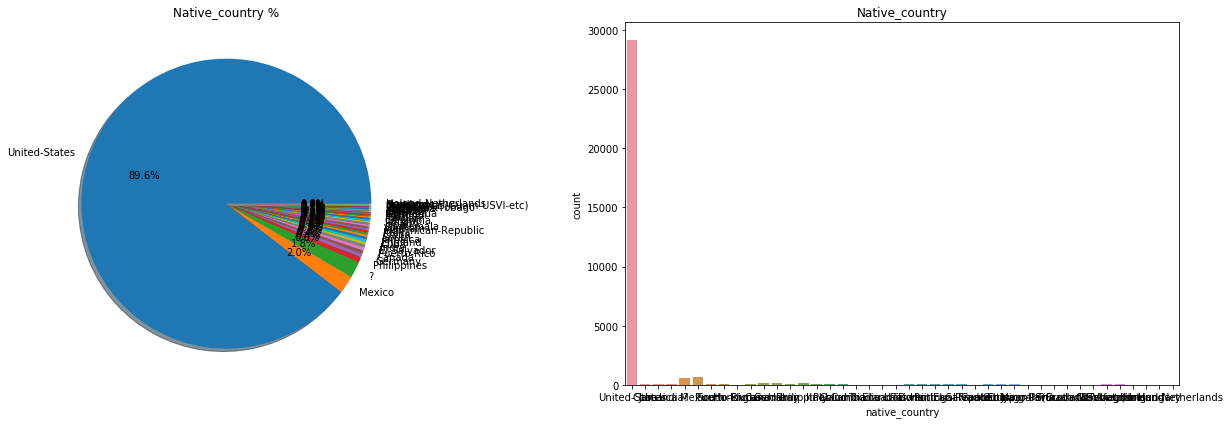

In [18]:
f,ax=plt.subplots(1,2,figsize=(18,6), tight_layout=True)
income['native_country'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Native_country %')
ax[0].set_ylabel('')
sns.countplot('native_country',data=income,ax=ax[1])
ax[1].set_title('Native_country')
plt.show()

**5）Interaction - Occupation & Sex**  
Sex distributed differently among different occupations

Text(0, 0.5, 'Count')

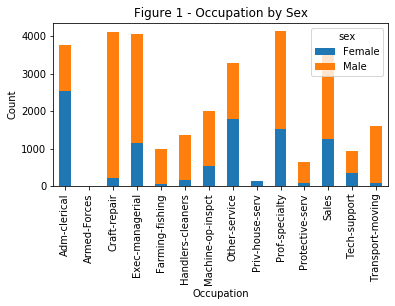

In [19]:
occu = income[income['occupation'] != "?"]
pd.crosstab(occu["occupation"],occu['sex']).plot(kind='bar', figsize = (6,3), stacked=True)
plt.title('Figure 1 - Occupation by Sex')
plt.xlabel('Occupation')
plt.ylabel('Count')

**5）Interaction - Education & Sex**  
Sex distributed differently among different education levels

Text(0, 0.5, 'Count')

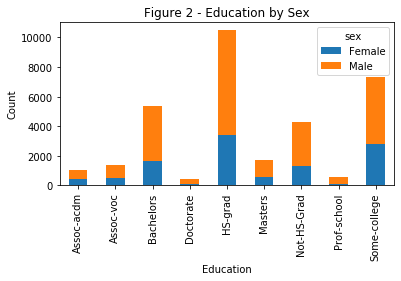

In [20]:
pd.crosstab(income['education'],income['sex']).plot(kind='bar', figsize = (6,3), stacked=True)
plt.title('Figure 2 - Education by Sex')
plt.xlabel('Education')
plt.ylabel('Count')

### Part 2. Recursive Feature Elimination

**1) clean data based on EDA**  

In [21]:
# relevel education variable and change it to ordinal factor 
mapper = {'Not-HS-Grad':1,'HS-grad':2,'Some-college':3,"Assoc-voc":4,"Assoc-acdm":5,"Bachelors":6,"Masters":7, "Prof-school":8, "Doctorate":9}
income_raw['ordedu'] = income_raw['education'].map(mapper)

In [22]:
income_raw['investment'] = np.where(((income_raw["capital_gain"] == 0) & (income_raw["capital_loss"] == 0)), 0, 1)

In [23]:
# assigning levels to the values of categorical variables
factors = ['workclass', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'investment', 'native_country', 'income']
income_raw = income_raw.drop('education', 1)
income_fact = income_raw.copy()
mapping_levels = []
for factor in factors:
    income_fact[factor] = income_fact[factor].factorize(sort = True)[0]
    mapping_levels.append(income_fact[factor].factorize(sort = True)[1])
income_fact.head()

,age,workclass,fnlwgt,occupation,relationship,race,sex,income,marital_status,education_num,capital_gain,capital_loss,hours_per_week,native_country,ordedu,investment
0,39,7,77516,1,1,4,1,0,4,13,2174,0,40,39,6,1
1,50,6,83311,4,0,4,1,0,2,13,0,0,13,39,6,0
2,38,4,215646,6,1,4,1,0,0,9,0,0,40,39,2,0
3,53,4,234721,6,0,2,1,0,2,7,0,0,40,39,1,0
4,28,4,338409,10,5,2,0,0,2,13,0,0,40,5,6,0


In [24]:
y = income_fact[['income']]
X = income_fact.loc[:, income_fact.columns != 'income']

In [25]:
X.columns

Index(['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race',
       'sex', 'marital_status', 'education_num', 'capital_gain',
       'capital_loss', 'hours_per_week', 'native_country', 'ordedu',
       'investment'],
      dtype='object')

**2) perform RFE**

In [26]:
model = LogisticRegression()
rfe = RFE(model, 10)
fit = rfe.fit(X,y)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number

Num Features: 10
Selected Features: [False  True False False  True  True  True  True  True False False  True
  True  True  True]
Feature Ranking: [2 1 6 3 1 1 1 1 1 5 4 1 1 1 1]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


# Logistic Regression Model (Q4)

**1) drop features based on feature selection technique**

In [27]:
drop = ['fnlwgt', 'occupation', 'age', 'race', 'capital_gain', 'capital_loss', 'native_country']
income_fact = income_fact.drop(drop,1)

**2) create indicator variables**

In [28]:
df_income = income_fact.copy()
factors1 = ['workclass', 'marital_status', 'relationship', 'sex', 'investment', 'income']
for var in factors1:
    if var != 'income':
        cat_list='var'+'_'+var
        cat_list = pd.get_dummies(df_income[var], prefix=var, drop_first=True)
        df_income = pd.concat([df_income,cat_list], axis = 1)
        df_income = df_income.drop(var, 1)

df_income['income'] = df_income['income'].factorize()[0]
df_income.head()

,income,education_num,hours_per_week,ordedu,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,...,marital_status_4,marital_status_5,marital_status_6,relationship_1,relationship_2,relationship_3,relationship_4,relationship_5,sex_1,investment_1
0,0,13,40,6,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,1
1,0,13,13,6,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,0,9,40,2,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,7,40,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,13,40,6,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


**3) Test-Training Set Split; oversampling using SMOTE**

In [29]:
os = SMOTE(random_state=0)
X_train, X_test, Y_train, Y_test = train_test_split(df_income.drop('income',axis=1),df_income['income'], test_size=0.30, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, Y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['income'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of income less than 50k in oversampled data",len(os_data_y[os_data_y['income']==0]))
print("Number of income more than 50k",len(os_data_y[os_data_y['income']==1]))
print("Proportion of income less than 50k data in oversampled data is ",len(os_data_y[os_data_y['income']==0])/len(os_data_X))
print("Proportion of income more than 50k data in oversampled data is ",len(os_data_y[os_data_y['income']==1])/len(os_data_X))

length of oversampled data is  34626
Number of income less than 50k in oversampled data 17313
Number of income more than 50k 17313
Proportion of income less than 50k data in oversampled data is  0.5
Proportion of income more than 50k data in oversampled data is  0.5


**4) logistic model building**

In [30]:
logreg = LogisticRegression()
logreg = logreg.fit(X_train, Y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [31]:
Y_pred = logreg.predict(X_test)
confusion_matrix = confusion_matrix(Y_test, Y_pred)
print(confusion_matrix)

[[6819  588]
 [1043 1319]]


In [32]:
print("Accuracy:",logreg.score(X_train, Y_train))
print("Precision:",metrics.precision_score(Y_test, Y_pred))
print("Recall:",metrics.recall_score(Y_test, Y_pred))

Accuracy: 0.8342839592839593
Precision: 0.6916622968012586
Recall: 0.5584250635055038


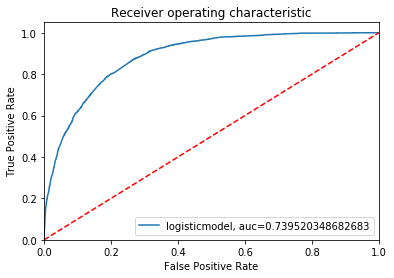

In [33]:
# ROC curve and AUC
logit_roc_auc = roc_auc_score(Y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(Y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label="logisticmodel, auc="+str(logit_roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [34]:
# Positive coefficients increase the log-odds of the response (and thus increase the probability) 
# negative coefficients decrease the log-odds of the response (and thus decrease the probability).
coeff_df = pd.DataFrame(X_train.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])
from regressors import stats
coeff_df['pvals'] = pd.Series(stats.coef_pval(logreg, X_train, Y_train))

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation,pvals
21,sex_1,1.048625,0.000000
22,investment_1,0.786638,0.000000
3,workclass_2,0.496874,0.000000
7,workclass_6,0.294758,0.000000
12,marital_status_3,0.278260,0.268861
0,hours_per_week,0.227478,0.000000
2,workclass_1,0.142904,0.000000
11,marital_status_2,0.129295,0.416736
6,workclass_5,0.071159,0.939342
4,workclass_3,0.033591,0.000000


# Linear Regression - work hours (Q5)

**1) prepare data for linear regression**

In [35]:
income_new = income_raw.copy()
factors = ['workclass', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'investment', 'native_country', 'income']

mapping_levels = []
for factor in factors:
    income_new[factor] = income_new[factor].factorize(sort = True)[0]
    mapping_levels.append(income_new[factor].factorize(sort = True)[1])
income_new.head()

,age,workclass,fnlwgt,occupation,relationship,race,sex,income,marital_status,education_num,capital_gain,capital_loss,hours_per_week,native_country,ordedu,investment
0,39,7,77516,1,1,4,1,0,4,13,2174,0,40,39,6,1
1,50,6,83311,4,0,4,1,0,2,13,0,0,13,39,6,0
2,38,4,215646,6,1,4,1,0,0,9,0,0,40,39,2,0
3,53,4,234721,6,0,2,1,0,2,7,0,0,40,39,1,0
4,28,4,338409,10,5,2,0,0,2,13,0,0,40,5,6,0


In [36]:
# RFE for linear regression variable selection
y_rfe = income_new[['hours_per_week']]
X_rfe = income_new.loc[:, income_new.columns != 'hours_per_week']
model_select_feature = LinearRegression()
rfe = RFE(model_select_feature, 10)
fit = rfe.fit(X_rfe,y_rfe)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

Num Features: 10
Selected Features: [False  True False  True  True  True  True  True  True  True False False
 False  True  True]
Feature Ranking: [2 1 6 1 1 1 1 1 1 1 5 4 3 1 1]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [37]:
X_rfe.columns

Index(['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race',
       'sex', 'income', 'marital_status', 'education_num', 'capital_gain',
       'capital_loss', 'native_country', 'ordedu', 'investment'],
      dtype='object')

In [38]:
# drop features based on RFE, FDR, and EDA
# In EDA, race data is biased since most are white people.
#Besides, the eudcation_num and ordedu are correlated, so only ordedu is kept for analysis.
# In RFE, age, fnlwgt, capital_gain, capital_loss and native_country should be dropped.

drop_var = ['age', 'fnlwgt', 'education_num', "race", 'capital_gain', 'capital_loss', 'native_country']
income_new = income_new.drop(drop_var,1)

In [39]:
income_new['sexedu'] = income_new['sex']*income_new['ordedu']
income_new['sexoccu'] = income_new['sex']*income_new['occupation']
income_new['sexmarital'] = income_new['sex']*income_new['marital_status']
income_new['sexincome'] = income_new['sex']*income_new['income']
income_new['ordeduincome'] = income_new['income']*income_new['ordedu']
income_new['investincome'] = income_new['income']*income_new['investment']

In [40]:
# create indicator variables
df_income_new = income_new.copy()
factors2 = ['workclass', 'marital_status', "occupation", 'relationship', 'sex', 
            'income', 'sexedu', 'sexoccu', 'sexmarital', 'sexincome', 'ordeduincome', 'investincome']
for var in factors2:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(df_income_new[var], prefix=var, drop_first=True)
    df_income_new = pd.concat([df_income_new,cat_list], axis = 1)
    df_income_new = df_income_new.drop(var, 1)

df_income_new.head()

,hours_per_week,ordedu,investment,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,...,ordeduincome_1,ordeduincome_2,ordeduincome_3,ordeduincome_4,ordeduincome_5,ordeduincome_6,ordeduincome_7,ordeduincome_8,ordeduincome_9,investincome_1
0,40,6,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,13,6,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,40,2,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,40,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,40,6,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**2) Linear Model Building - Plain model without interactions**

In [51]:
variables = ['ordedu', 'investment', 'workclass_1', 'workclass_2', 'workclass_3',
       'workclass_4', 'workclass_5', 'workclass_6', 'workclass_7',
       'workclass_8', 'marital_status_1', 'marital_status_2',
       'marital_status_3', 'marital_status_4', 'marital_status_5',
       'marital_status_6', 'occupation_1', 'occupation_2', 'occupation_3',
       'occupation_4', 'occupation_5', 'occupation_6', 'occupation_7',
       'occupation_8', 'occupation_9', 'occupation_10', 'occupation_11',
       'occupation_12', 'occupation_13', 'occupation_14', 'relationship_1',
       'relationship_2', 'relationship_3', 'relationship_4', 'relationship_5',
       'sex_1', 'income_1']
y1 = df_income_new[['hours_per_week']]
X1 = sm.add_constant(df_income_new.loc[:,variables])

linear_model = sm.OLS(y1,X1)
print("Number of predictors is : "+str(X1.shape[1]))
fit = linear_model.fit()
fit.summary()

Number of predictors is : 38


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         hours_per_week   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     209.5
Date:                Sat, 18 Jan 2020   Prob (F-statistic):               0.00
Time:                        12:51:39   Log-Likelihood:            -1.2465e+05
No. Observations:               32561   AIC:                         2.494e+05
Df Residuals:                   32524   BIC:                         2.497e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               30.4699      0.844     36.120      0.000      28.816      32.123
ordedu               0.4521      0.040     11.394      0.000       0.374       0.530
investment           0.2864      0.193      1.481      0.139      -0.093       0.665
workclass_1          4.1475      0.443      9.363      0.000       3.279       5.016
workclass_2          4.2292      0.380     11.140      0.000       3.485       4.973
workclass_3         -0.8545      4.217     -0.203      0.839      -9.119       7.410
workclass_4          4.5656      0.303     15.069      0.000       3.972       5.159
workclass_5          9.2854      0.441     21.055      0.000       8.421      10.150
workclass_6          5.9197      0.367     16.135      0.000       5.201       6.639
workclass_7          2.3688      0.419      5.647      0.000       1.547       3.191
workclass_8         -2.3771      2.849     -0.834      0.404      -7.962       3.207
marital_status_1     3.1284      2.434      1.285      0.199      -1.642       7.899
marital_status_2     0.8147      0.774      1.053      0.292      -0.702       2.331
marital_status_3    -1.2892      0.571     -2.259      0.024      -2.408      -0.171
marital_status_4    -1.9834      0.219     -9.059      0.000      -2.413      -1.554
marital_status_5    -0.9021      0.387     -2.330      0.020      -1.661      -0.143
marital_status_6    -6.6482      0.395    -16.822      0.000      -7.423      -5.874
occupation_1         0.7344      0.309      2.373      0.018       0.128       1.341
occupation_2         2.0216      3.555      0.569      0.570      -4.947       8.990
occupation_3         2.4022      0.310      7.755      0.000       1.795       3.009
occupation_4         3.7725      0.311     12.117      0.000       3.162       4.383
occupation_5         7.5309      0.426     17.677      0.000       6.696       8.366
occupation_6         0.6545      0.389      1.682      0.093      -0.108       1.417
occupation_7         2.5485      0.353      7.212      0.000       1.856       3.241
occupation_8        -1.4841      0.318     -4.673      0.000      -2.106      -0.862
occupation_9        -2.1650      0.911     -2.375      0.018      -3.952      -0.379
occupation_10        1.5127      0.323      4.679      0.000       0.879       2.146
occupation_11        3.4581      0.500      6.911      0.000       2.477       4.439
occupation_12        1.6808      0.313      5.372      0.000       1.068       2.294
occupation_13        0.2616      0.433      0.604      0.546      -0.588       1.111
occupation_14        5.2104      0.373     13.983      0.000       4.480       5.941
relationship_1       2.4046      0.771      3.118      0.002       0.893       3.916
relationship_2      -0.1605      0.758     -0.212      0.832      -1.646       1.325
relationship_3      -3.

**3) Linear Model Building - Full model with interactions**

In [52]:
y2 = df_income_new[['hours_per_week']]
X2 = sm.add_constant(df_income_new.loc[:, df_income_new.columns != 'hours_per_week'])

print("Number of predictors is : "+str(X2.shape[1]))

linear_model2 = sm.OLS(y2,X2)
fit2 = linear_model2.fit()
fit2.summary()


Number of predictors is : 78


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         hours_per_week   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     108.5
Date:                Sat, 18 Jan 2020   Prob (F-statistic):               0.00
Time:                        12:51:44   Log-Likelihood:            -1.2449e+05
No. Observations:               32561   AIC:                         2.491e+05
Df Residuals:                   32487   BIC:                         2.497e+05
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               28.3013      1.089     25.987      0.000      26.167      30.436
ordedu               0.7048      0.073      9.682      0.000       0.562       0.848
investment           0.2191      0.274      0.800      0.424      -0.318       0.756
workclass_1          3.7251      0.474      7.861      0.000       2.796       4.654
workclass_2          3.6791      0.409      9.000      0.000       2.878       4.480
workclass_3         -0.3858      4.200     -0.092      0.927      -8.618       7.846
workclass_4          4.0199      0.338     11.893      0.000       3.357       4.682
workclass_5          8.4177      0.468     18.000      0.000       7.501       9.334
workclass_6          5.1245      0.399     12.852      0.000       4.343       5.906
workclass_7          1.8142      0.446      4.070      0.000       0.941       2.688
workclass_8         -3.0203      2.840     -1.064      0.288      -8.586       2.545
marital_status_1    -4.7588      3.130     -1.521      0.128     -10.893       1.375
marital_status_2    -0.9211      1.122     -0.821      0.412      -3.120       1.278
marital_status_3    -1.4672      0.805     -1.824      0.068      -3.044       0.110
marital_status_4    -1.9666      0.289     -6.816      0.000      -2.532      -1.401
marital_status_5    -0.5736      0.494     -1.160      0.246      -1.542       0.395
marital_status_6    -5.9766      0.447    -13.374      0.000      -6.853      -5.101
occupation_1         1.3594      0.338      4.019      0.000       0.696       2.022
occupation_2         1.1253      1.827      0.616      0.538      -2.455       4.706
occupation_3         4.0490      0.758      5.344      0.000       2.564       5.534
occupation_4         4.1883      0.422      9.933      0.000       3.362       5.015
occupation_5         3.2045      1.329      2.412      0.016       0.600       5.809
occupation_6         1.9409      0.867      2.238      0.025       0.241       3.641
occupation_7         4.0888      0.527      7.761      0.000       3.056       5.121
occupation_8        -1.0478      0.367     -2.854      0.004      -1.767      -0.328
occupation_9        -2.0571      0.931     -2.209      0.027      -3.882      -0.232
occupation_10        1.4580      0.426      3.420      0.001       0.623       2.293
occupation_11        3.3086      1.241      2.666      0.008       0.876       5.741
occupation_12       -0.5366      0.402     -1.336      0.181      -1.324       0.251
occupation_13        0.9941      0.629      1.580      0.114      -0.239       2.228
occupation_14        1.6845      1.142      1.475      0.140      -0.555       3.924
relationship_1       4.0877      0.984      4.153      0.000       2.159       6.017
relationship_2       1.6412      0.973      1.686      0.092      -0.266       3.549
relationship_3      -1.

**4) Linear Model Building - Reduced model with only significant variables**

In [43]:
# get a list of insignificant variables (except for dummy variables)
p_values2 = fit2.summary2().tables[1]['P>|t|']
p_summary = p_values2.reset_index()
n = len(p_summary['index'])

insign_list = []
deleteable = ['ordedu', 'investment', 'investincome_1']
for i in range(n):
    if (p_summary['P>|t|'][i] > 0.05) & (p_summary['index'][i] in deleteable): 
            insign_list.append(p_summary['index'][i])
    else: continue
            
insign_list     

['investment', 'investincome_1']

In [53]:
insign_list.append('hours_per_week')
X3 = sm.add_constant(df_income_new.drop(df_income_new[insign_list],1))

print("Number of predictors is : "+str(X3.shape[1]))

linear_model3 = sm.OLS(y2,X3)
fit3 = linear_model3.fit()
fit3.summary()

Number of predictors is : 76


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         hours_per_week   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     111.6
Date:                Sat, 18 Jan 2020   Prob (F-statistic):               0.00
Time:                        12:51:49   Log-Likelihood:            -1.2449e+05
No. Observations:               32561   AIC:                         2.491e+05
Df Residuals:                   32489   BIC:                         2.497e+05
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               28.3187      1.089     26.006      0.000      26.184      30.453
ordedu               0.7055      0.073      9.693      0.000       0.563       0.848
workclass_1          3.7207      0.474      7.852      0.000       2.792       4.650
workclass_2          3.6795      0.409      9.001      0.000       2.878       4.481
workclass_3         -0.3996      4.200     -0.095      0.924      -8.631       7.832
workclass_4          4.0185      0.338     11.889      0.000       3.356       4.681
workclass_5          8.4268      0.467     18.026      0.000       7.510       9.343
workclass_6          5.1267      0.399     12.858      0.000       4.345       5.908
workclass_7          1.8089      0.446      4.059      0.000       0.935       2.683
workclass_8         -3.0049      2.840     -1.058      0.290      -8.571       2.561
marital_status_1    -4.7721      3.129     -1.525      0.127     -10.906       1.362
marital_status_2    -0.9059      1.122     -0.808      0.419      -3.104       1.293
marital_status_3    -1.4663      0.804     -1.823      0.068      -3.043       0.111
marital_status_4    -1.9665      0.289     -6.816      0.000      -2.532      -1.401
marital_status_5    -0.5752      0.494     -1.164      0.245      -1.544       0.394
marital_status_6    -5.9712      0.447    -13.363      0.000      -6.847      -5.095
occupation_1         1.3586      0.338      4.016      0.000       0.696       2.022
occupation_2         1.1309      1.827      0.619      0.536      -2.449       4.711
occupation_3         4.0490      0.758      5.345      0.000       2.564       5.534
occupation_4         4.1847      0.422      9.925      0.000       3.358       5.011
occupation_5         3.2111      1.329      2.417      0.016       0.607       5.815
occupation_6         1.9362      0.867      2.233      0.026       0.236       3.636
occupation_7         4.0863      0.527      7.756      0.000       3.054       5.119
occupation_8        -1.0546      0.367     -2.873      0.004      -1.774      -0.335
occupation_9        -2.0586      0.931     -2.211      0.027      -3.884      -0.234
occupation_10        1.4633      0.426      3.433      0.001       0.628       2.299
occupation_11        3.3138      1.241      2.670      0.008       0.882       5.746
occupation_12       -0.5379      0.402     -1.339      0.180      -1.325       0.249
occupation_13        1.0023      0.629      1.593      0.111      -0.231       2.235
occupation_14        1.6911      1.142      1.480      0.139      -0.548       3.930
relationship_1       4.0860      0.984      4.152      0.000       2.157       6.015
relationship_2       1.6372      0.973      1.682      0.093      -0.270       3.545
relationship_3      -1.6184      0.980     -1.652      0.099      -3.539       0.302
relationship_4       3.

# Linear Regression - work hours for sales occupation (Q6)

In [45]:
# find out sales level in the occupation
print(income.occupation.unique())
print(income_new.occupation.unique())

['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' '?'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv']
[ 1  4  6 10  8 12  3 14  5  7 13  0 11  2  9]


In [46]:
# create indicator variables
df_income_q6 = income_new.loc[income_new['occupation']==12]
factors2 = ['workclass', 'marital_status', "occupation", 'relationship', 'sex', 
            'income', 'sexedu', 'sexoccu', 'sexmarital', 'sexincome', 'ordeduincome', 'investincome']
for var in factors2:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(df_income_q6[var], prefix=var, drop_first=True)
    df_income_q6 = pd.concat([df_income_q6,cat_list], axis = 1)
    df_income_q6 = df_income_q6.drop(var, 1)

df_income_q6.head()

,hours_per_week,ordedu,investment,workclass_2,workclass_4,workclass_5,workclass_6,workclass_7,marital_status_1,marital_status_2,...,ordeduincome_1,ordeduincome_2,ordeduincome_3,ordeduincome_4,ordeduincome_5,ordeduincome_6,ordeduincome_7,ordeduincome_8,ordeduincome_9,investincome_1
13,50,5,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,50,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
31,44,3,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38,38,3,0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
60,40,6,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [50]:
y_q6 = df_income_q6[['hours_per_week']]
X_q6 = sm.add_constant(df_income_q6.loc[:, df_income_q6.columns != 'hours_per_week'])

print("Number of predictors is : "+str(X_q6.shape[1]))

linear_model_q6 = sm.OLS(y_q6,X_q6)
fit_q6 = linear_model_q6.fit()
fit_q6.summary()

Number of predictors is : 48


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         hours_per_week   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     32.94
Date:                Sat, 18 Jan 2020   Prob (F-statistic):          6.01e-228
Time:                        12:50:14   Log-Likelihood:                -13990.
No. Observations:                3650   AIC:                         2.807e+04
Df Residuals:                    3605   BIC:                         2.835e+04
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               35.8192      4.293      8.344      0.000      27.402      44.236
ordedu               1.2632      0.207      6.099      0.000       0.857       1.669
investment           0.7523      0.833      0.903      0.367      -0.882       2.386
workclass_2         -4.0157      5.312     -0.756      0.450     -14.430       6.398
workclass_4         -1.0758      3.155     -0.341      0.733      -7.262       5.110
workclass_5          3.6285      3.212      1.130      0.259      -2.668       9.925
workclass_6          1.1720      3.197      0.367      0.714      -5.097       7.441
workclass_7         -4.3468      4.630     -0.939      0.348     -13.425       4.731
marital_status_1     3.9448     12.118      0.326      0.745     -19.813      27.703
marital_status_2    -1.5524      3.095     -0.502      0.616      -7.621       4.516
marital_status_3    -1.2485      2.560     -0.488      0.626      -6.268       3.771
marital_status_4    -3.6630      0.891     -4.110      0.000      -5.410      -1.916
marital_status_5    -2.3728      1.550     -1.530      0.126      -5.413       0.667
marital_status_6    -6.2760      1.426     -4.402      0.000      -9.071      -3.481
relationship_1       1.3948      2.799      0.498      0.618      -4.093       6.882
relationship_2      -1.8754      2.768     -0.678      0.498      -7.302       3.551
relationship_3      -7.1161      2.766     -2.573      0.010     -12.540      -1.693
relationship_4       0.6024      2.862      0.210      0.833      -5.010       6.214
relationship_5      -2.2905      3.842     -0.596      0.551      -9.823       5.242
sex_1                1.5706      0.665      2.362      0.018       0.267       2.874
income_1             3.8849      1.525      2.547      0.011       0.894       6.875
sexedu_1            -0.7134      1.398     -0.510      0.610      -3.454       2.027
sexedu_2             4.0561      1.067      3.801      0.000       1.964       6.148
sexedu_3             1.7908      1.000      1.790      0.073      -0.170       3.752
sexedu_4             2.3256      1.580      1.471      0.141      -0.773       5.424
sexedu_5             1.9110      1.462      1.307      0.191      -0.956       4.778
sexedu_6            -0.0793      1.018     -0.078      0.938      -2.075       1.916
sexedu_7            -2.7899      1.724     -1.618      0.106      -6.171       0.591
sexedu_8            -6.4541      3.633     -1.776      0.076     -13.578       0.669
sexedu_9             1.5238      5.247      0.290      0.772      -8.764      11.811
sexoccu_12           1.5706      0.665      2.362      0.018       0.267       2.874
sexmarital_1         6.5880     16.708      0.394      0.693     -26.170      39.346
sexmarital_2         0.9270      3.900      0.238      0.812      -6.720       8.574
sexmarital_3        -0.